In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read training/test data from csv files. Please give path according to location of file at your system
train=pd.read_csv("training.csv", sep=';', decimal=',')
test=pd.read_csv("validation.csv", sep=';', decimal=',')

In [3]:
train.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
0,a,17.92,0.000054,u,-0.840182,0.522883,1.750,f,t,1,t,g,80.0,5,800000.0,t,0,no.
1,b,16.92,0.000034,y,-2.159635,0.774187,0.290,f,f,0,f,s,200.0,0,2000000.0,NaN,0,no.
2,b,31.25,0.000112,u,1.750687,0.760363,0.000,f,t,1,f,g,96.0,19,960000.0,t,0,no.
3,a,48.17,0.000133,u,4.174871,0.888963,0.335,f,f,0,f,g,0.0,120,0.0,NaN,0,no.
4,b,32.33,0.000350,u,-3.785479,0.489024,0.500,f,f,0,t,g,232.0,0,2320000.0,f,0,no.


In [4]:
train.dtypes

v1             object
v2            float64
v3            float64
v4             object
v5            float64
v6            float64
v7            float64
v8             object
v9             object
v10             int64
v11            object
v12            object
v13           float64
v14             int64
v15           float64
v16            object
v17             int64
classLabel     object
dtype: object

In [5]:
train.info()
train.isnull().sum()
# Finding 1 - variables v1,v2,v4,v13,v15,v16(more than 50% missing) have missing data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   v1          3661 non-null   object 
 1   v2          3661 non-null   float64
 2   v3          3700 non-null   float64
 3   v4          3636 non-null   object 
 4   v5          3700 non-null   float64
 5   v6          3700 non-null   float64
 6   v7          3700 non-null   float64
 7   v8          3700 non-null   object 
 8   v9          3700 non-null   object 
 9   v10         3700 non-null   int64  
 10  v11         3700 non-null   object 
 11  v12         3700 non-null   object 
 12  v13         3600 non-null   float64
 13  v14         3700 non-null   int64  
 14  v15         3600 non-null   float64
 15  v16         1555 non-null   object 
 16  v17         3700 non-null   int64  
 17  classLabel  3700 non-null   object 
dtypes: float64(7), int64(3), object(8)
memory usage: 520.4+ KB


v1              39
v2              39
v3               0
v4              64
v5               0
v6               0
v7               0
v8               0
v9               0
v10              0
v11              0
v12              0
v13            100
v14              0
v15            100
v16           2145
v17              0
classLabel       0
dtype: int64

In [6]:
train.nunique().sort_values()

v1               2
v16              2
v11              2
v17              2
v8               2
v9               2
classLabel       2
v4               3
v12              3
v10             23
v7             118
v13            136
v15            136
v3             179
v14            182
v2             288
v5            3700
v6            3700
dtype: int64

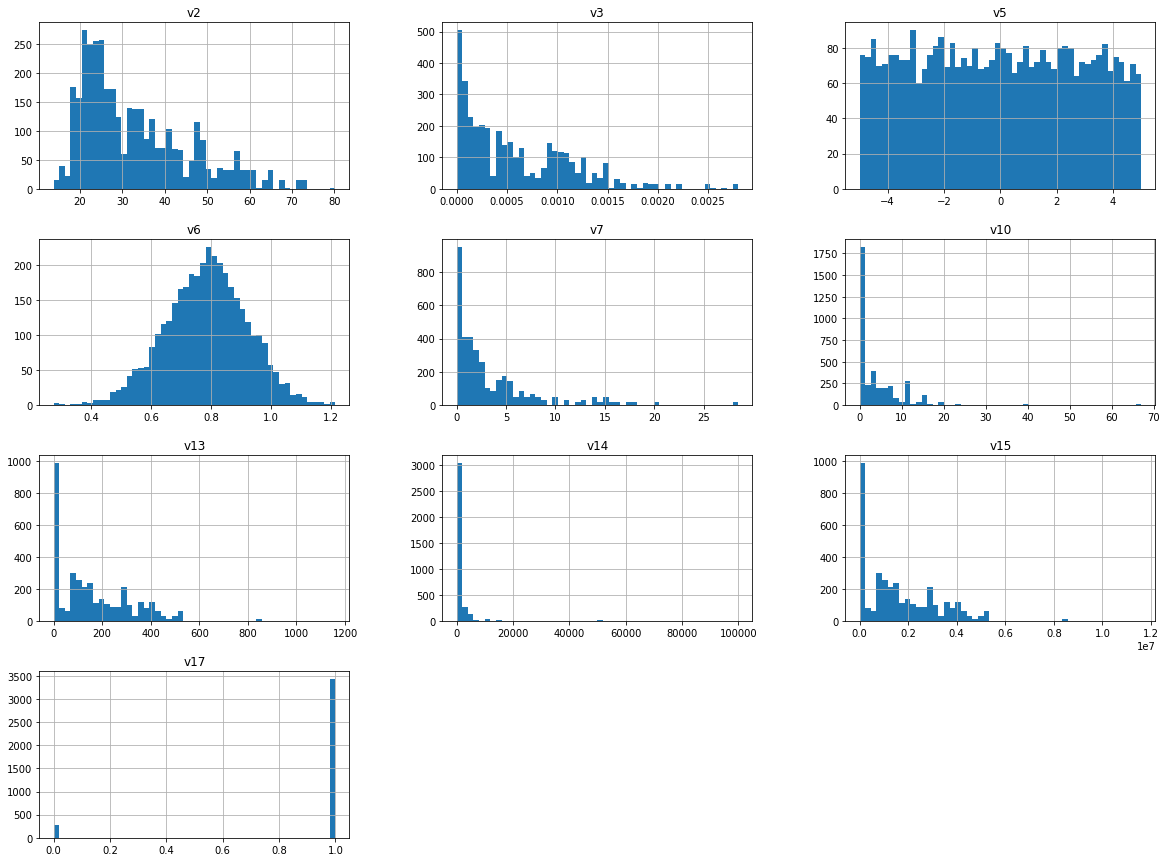

In [7]:
%matplotlib inline
train.hist(bins=50,figsize=(20,15))
plt.show()
## Finding 5 - data is positive skewed for v2,v3,v7,v10,v13,v14,v15. v6 is bell shaped distribution 

In [8]:
train.describe()
# Finding 2 - 9 numeric variables (v2,v3,v5,v6,v7,v10,v13,v14,v15) -  v17 is numeric categorial variable

,v2,v3,v5,v6,v7,v10,v13,v14,v15,v17
count,3661.000000,3700.000000,3700.000000,3700.000000,3700.000000,3700.000000,3600.000000,3700.000000,3.600000e+03,3700.000000
mean,32.820713,0.000585,-0.053318,0.784188,3.439496,4.160000,162.695000,2246.705946,1.626950e+06,0.925405
std,12.666181,0.000540,2.871240,0.136514,4.335229,6.750553,156.045682,8708.571126,1.560457e+06,0.262772
min,13.750000,0.000000,-4.996939,0.273945,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,23.000000,0.000150,-2.516349,0.693130,0.500000,0.000000,0.000000,0.000000,0.000000e+00,1.000000
50%,28.670000,0.000425,-0.052786,0.787842,1.750000,2.000000,120.000000,113.000000,1.200000e+06,1.000000
75%,40.830000,0.000963,2.406251,0.876052,5.000000,6.000000,280.000000,1059.750000,2.800000e+06,1.000000
max,80.250000,0.002800,4.999274,1.215066,28.500000,67.000000,1160.000000,100000.000000,1.160000e+07,1.000000


In [9]:
train.describe(include='all')
# Finding 3 - 8 categorical variables (v1,v4,v8,v9,v11,v12,v16,v17) and classLabel is target label
# Finding 4 - v14 has significant outliers

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,classLabel
count,3661,3661.000000,3700.000000,3636,3700.000000,3700.000000,3700.000000,3700,3700,3700.000000,3700,3700,3600.000000,3700.000000,3.600000e+03,1555,3700.000000,3700
unique,2,NaN,NaN,3,NaN,NaN,NaN,2,2,NaN,2,3,NaN,NaN,NaN,2,NaN,2
top,b,NaN,NaN,u,NaN,NaN,NaN,t,t,NaN,f,g,NaN,NaN,NaN,t,NaN,yes.
freq,2382,NaN,NaN,3055,NaN,NaN,NaN,3171,2239,NaN,1924,3430,NaN,NaN,NaN,1023,NaN,3424
mean,NaN,32.820713,0.000585,NaN,-0.053318,0.784188,3.439496,NaN,NaN,4.160000,NaN,NaN,162.695000,2246.705946,1.626950e+06,NaN,0.925405,NaN
std,NaN,12.666181,0.000540,NaN,2.871240,0.136514,4.335229,NaN,NaN,6.750553,NaN,NaN,156.045682,8708.571126,1.560457e+06,NaN,0.262772,NaN
min,NaN,13.750000,0.000000,NaN,-4.996939,0.273945,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000e+00,NaN,0.000000,NaN
25%,NaN,23.000000,0.000150,NaN,-2.516349,0.693130,0.500000,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000e+00,NaN,1.000000,NaN
50%,NaN,28.670000,0.000425,NaN,-0.052786,0.787842,1.750000,NaN,NaN,2.000000,NaN,NaN,120.000000,113.000000,1.200000e+06,NaN,1.000000,NaN
75%,NaN,40.830000,0.000963,NaN,2.406251,0.876052,5.000000,NaN,NaN,6.000000,NaN,NaN,280.000000,1059.750000,2.800000e+06,NaN,1.000000,NaN


In [10]:
train['v17'].unique()

array([0, 1], dtype=int64)

array([[<AxesSubplot:xlabel='v2', ylabel='v2'>,
        <AxesSubplot:xlabel='v3', ylabel='v2'>,
        <AxesSubplot:xlabel='v5', ylabel='v2'>,
        <AxesSubplot:xlabel='v6', ylabel='v2'>,
        <AxesSubplot:xlabel='v7', ylabel='v2'>,
        <AxesSubplot:xlabel='v10', ylabel='v2'>,
        <AxesSubplot:xlabel='v13', ylabel='v2'>,
        <AxesSubplot:xlabel='v14', ylabel='v2'>,
        <AxesSubplot:xlabel='v15', ylabel='v2'>,
        <AxesSubplot:xlabel='v17', ylabel='v2'>],
       [<AxesSubplot:xlabel='v2', ylabel='v3'>,
        <AxesSubplot:xlabel='v3', ylabel='v3'>,
        <AxesSubplot:xlabel='v5', ylabel='v3'>,
        <AxesSubplot:xlabel='v6', ylabel='v3'>,
        <AxesSubplot:xlabel='v7', ylabel='v3'>,
        <AxesSubplot:xlabel='v10', ylabel='v3'>,
        <AxesSubplot:xlabel='v13', ylabel='v3'>,
        <AxesSubplot:xlabel='v14', ylabel='v3'>,
        <AxesSubplot:xlabel='v15', ylabel='v3'>,
        <AxesSubplot:xlabel='v17', ylabel='v3'>],
       [<AxesSubplot:xlabel=

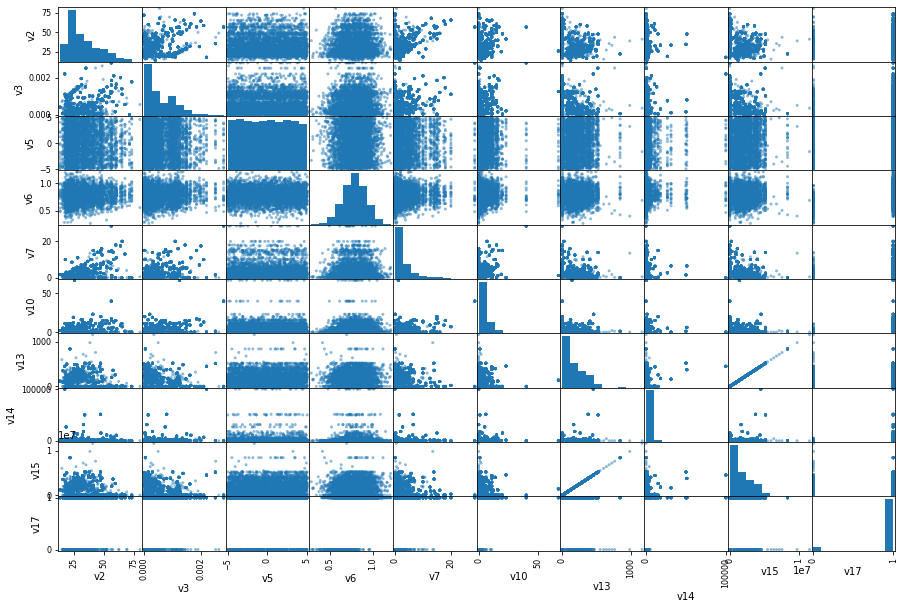

In [11]:
scatter_matrix(train,figsize=(15,10))
# Finding 6 - v13 and v15 have linear relation. After checking corrlation and data, it is apprent that v15 =v13*10000. 
# Hence it is redudent feature and one can be remove

In [12]:
def histplot_by_hue(data):
    j=0
    k=0
    for i in range(17):
        sns.histplot(data=data, x=data.iloc[:,i], hue='classLabel', kde=True,ax=axs[j,k])
        if (k==2):
            k=0
            j=j+1
        else:
            k=k+1
        
    

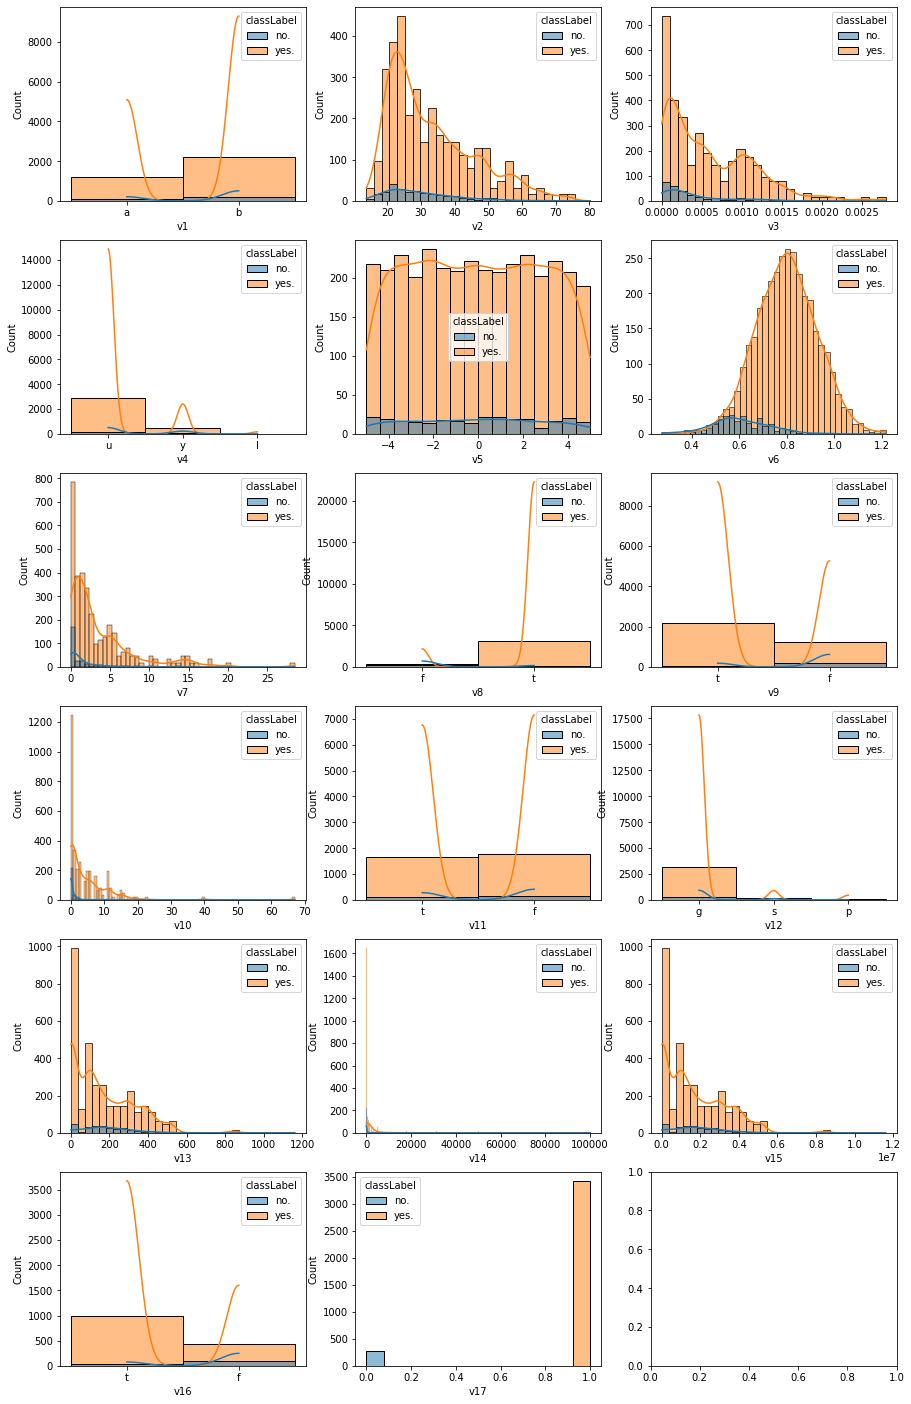

In [13]:
fig, axs = plt.subplots(6, 3,figsize=(15,25))
histplot_by_hue(train)

# Finding 7 - variable v17 is having value 0 for label no and 1 for yes

# In real project v17 should be explored more to understand its significance in business context. There could be 3 possibilities
# 1. It is numeric representation of label and provided as variable erroneously (may be introduced purposely),
# 2. If not case 1, more training data required with different behavior of v17 in relation with classlabel
# 3. If not case 1 and 2, there is no need of model, this variable alone can predict classes.
#    However here removing v17 considering case 1 or 2

# Finding 8 - seems v14 has significant outliers. Need to explore further using boxplot.
# Finding 9 - many variables are positive skewed
# Finding 10 - center value of v6 for both classes are distinct. It indicates correlation.

In [14]:
train['classLabel'].value_counts()

yes.    3424
no.      276
Name: classLabel, dtype: int64

In [15]:
df=train.loc[train['classLabel']=='yes.']
df['v17'].value_counts()

1    3424
Name: v17, dtype: int64

In [16]:
df=train.loc[train['classLabel']=='no.']
df['v17'].value_counts()

0    276
Name: v17, dtype: int64

<AxesSubplot:>

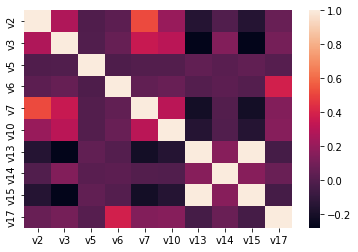

In [17]:
corr=train.corr()
sns.heatmap(corr)
# Finding 11 - v13 and v15 has correlation factor 1 means redudent feature and can be dropped.
# Data also shows column v15 = V13 * 10000  

<AxesSubplot:xlabel='v2', ylabel='classLabel'>

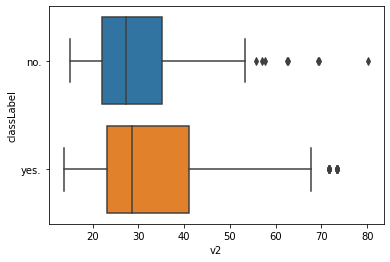

In [18]:
sns.boxplot(x='v2',y='classLabel',data=train)

<AxesSubplot:xlabel='v3', ylabel='classLabel'>

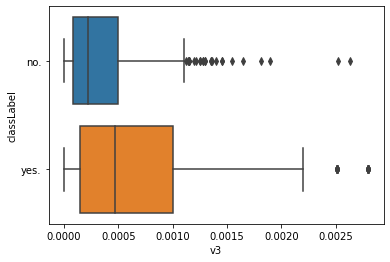

In [19]:
sns.boxplot(x='v3',y='classLabel',data=train)

<AxesSubplot:xlabel='v5', ylabel='classLabel'>

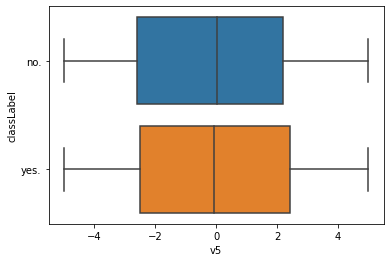

In [20]:
sns.boxplot(x='v5',y='classLabel',data=train)

<AxesSubplot:xlabel='v6', ylabel='classLabel'>

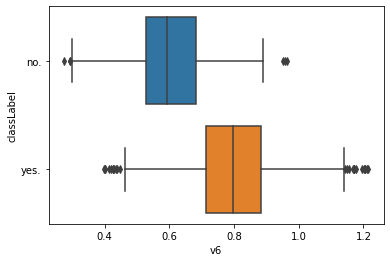

In [21]:
sns.boxplot(x='v6',y='classLabel',data=train)

<AxesSubplot:xlabel='v7', ylabel='classLabel'>

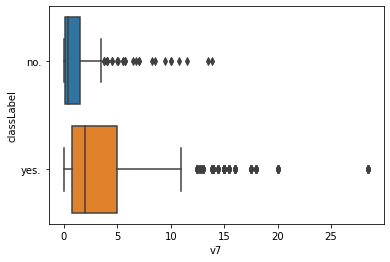

In [22]:
sns.boxplot(x='v7',y='classLabel',data=train)

<AxesSubplot:xlabel='v10', ylabel='classLabel'>

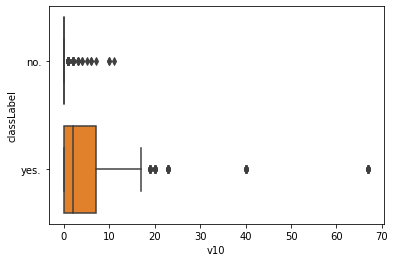

In [23]:
sns.boxplot(x='v10',y='classLabel',data=train)

<AxesSubplot:xlabel='v13', ylabel='classLabel'>

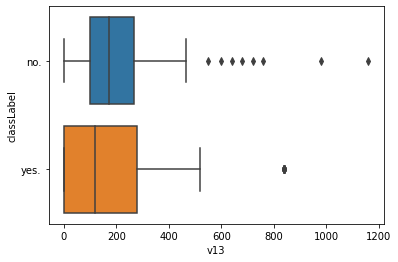

In [24]:
sns.boxplot(x='v13',y='classLabel',data=train)

<AxesSubplot:xlabel='v14', ylabel='classLabel'>

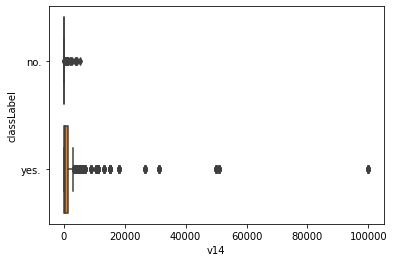

In [25]:
sns.boxplot(x='v14',y='classLabel',data=train)

<AxesSubplot:xlabel='v15', ylabel='classLabel'>

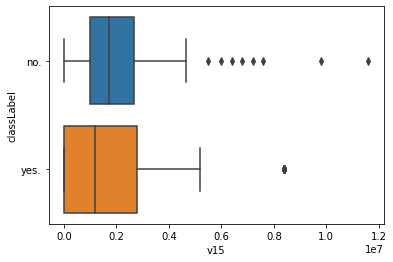

In [26]:
sns.boxplot(x='v15',y='classLabel',data=train)

In [27]:
# Data Preprocessing in training set

#Dropped column v16 as it has more than 50%missing data, 
#Dropped column v15 as it is V13 multiply by 10000  
#Dropped column v17 as it is 0 for No class and 1 for yes class.   
train=train.drop(['v16','v15','v17'], axis=1)

#Set missing data in v2,v13 numeric varibles to median. 
#Using median as these variables have outliers and median is less sensative to outliers compare to mean.  
median_v2=train['v2'].median()
median_v13=train['v13'].median()
train['v2'].fillna(median_v2, inplace=True)
train['v13'].fillna(median_v13, inplace=True)

#np.percentile(train["v14"], 99)
#50000.0
#train["v14"] = np.where(train["v14"] >50000, 50000,train['v14'])

#Set missing data in v1,v4 categorical varibles to mode. 
#Using mode to assign high frequency category.  
mode_v1=train['v1'].mode()
mode_v4=train['v4'].mode()
train['v1'].fillna(mode_v1[0], inplace=True)
train['v4'].fillna(mode_v4[0], inplace=True)

train["classLabel"].replace({"no.": 0, "yes.": 1}, inplace=True)

In [28]:
#Prepare test set with median and mode values saved from training set
test=test.drop(['v16','v15','v17'], axis=1)
test['v2'].fillna(median_v2, inplace=True)
test['v13'].fillna(median_v13, inplace=True)
test['v1'].fillna(mode_v1[0], inplace=True)
test['v4'].fillna(mode_v4[0], inplace=True)
test["classLabel"].replace({"no.": 0, "yes.": 1}, inplace=True)


In [29]:
#separate predictiors and label

X_train=train.drop('classLabel',axis=1)
y_train=train['classLabel'].copy()

X_test=test.drop('classLabel',axis=1)
y_test=test['classLabel'].copy()

In [30]:
# oneHot condoing tranformer

t = [('cat_v12', OneHotEncoder(categories=[['g','o','p','s']],sparse=False,handle_unknown='ignore'), ['v12']),
     ('cat', OneHotEncoder(sparse=False,handle_unknown='ignore'), ['v1','v4','v8','v9','v11'])
     ]
col_transform = ColumnTransformer(transformers=t,remainder='passthrough')

X_train_prepared= col_transform.fit_transform(X_train)

X_test_prepared= col_transform.transform(X_test)

col_transform.get_feature_names_out()

array(['cat_v12__v12_g', 'cat_v12__v12_o', 'cat_v12__v12_p',
       'cat_v12__v12_s', 'cat__v1_a', 'cat__v1_b', 'cat__v4_l',
       'cat__v4_u', 'cat__v4_y', 'cat__v8_f', 'cat__v8_t', 'cat__v9_f',
       'cat__v9_t', 'cat__v11_f', 'cat__v11_t', 'remainder__v2',
       'remainder__v3', 'remainder__v5', 'remainder__v6', 'remainder__v7',
       'remainder__v10', 'remainder__v13', 'remainder__v14'], dtype=object)

In [31]:
# creating decision tree as it is less sensetive to outliers. It is quite apperant in training set that there are outliers.
# decision tree do not need feture scaling, hence not doing StandardScaler

In [32]:
#from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train_prepared, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)

In [33]:
grid_search_cv.best_params_ 

{'max_leaf_nodes': 38, 'min_samples_split': 2}

In [34]:
#function to print score
def print_score(y_train,y_train_pred,set):
    print ('Confusion matrix on' , set, '\n', confusion_matrix(y_train,y_train_pred))
    print ('Precision on' , set,':\t',precision_score(y_train,y_train_pred))
    print ('Recall on  ',set,':\t',recall_score(y_train,y_train_pred))
    print ('F1 score on',set,':\t',f1_score(y_train,y_train_pred))
    print ('\n')

In [35]:
## iteration 1 Base Model Decision Tree classifier model
DT_model=DecisionTreeClassifier(max_leaf_nodes=38,min_samples_split=2)
cv = StratifiedKFold(n_splits=10,shuffle=True , random_state=42)

# evaluate model
y_train_pred = cross_val_predict(DT_model, X_train_prepared, y_train, cv=cv)

# print score
print_score(y_train,y_train_pred,'CV')

# fitting model in whole training set
DT_model.fit(X_train_prepared,y_train)

# prediction on test set
y_test_pred=DT_model.predict(X_test_prepared)

# score on test set
print_score(y_test,y_test_pred,'Test')

Confusion matrix on CV 
 [[ 201   75]
 [  29 3395]]
Precision on CV :	 0.978386167146974
Recall on   CV :	 0.9915303738317757
F1 score on CV :	 0.9849144183347838


Confusion matrix on Test 
 [[69 38]
 [ 6 87]]
Precision on Test :	 0.696
Recall on   Test :	 0.9354838709677419
F1 score on Test :	 0.7981651376146789




In [36]:
from sklearn.tree import export_graphviz

export_graphviz(DT_model,
                out_file=("BinaryClass.dot"),
                class_names=['no','yes'],
                rounded=True,
                filled=True )

Feature 0: 0.000000
Feature 1: 0.000000
Feature 2: 0.003443
Feature 3: 0.000000
Feature 4: 0.000000
Feature 5: 0.002101
Feature 6: 0.004247
Feature 7: 0.011778
Feature 8: 0.002073
Feature 9: 0.097000
Feature 10: 0.101251
Feature 11: 0.020721
Feature 12: 0.016703
Feature 13: 0.000000
Feature 14: 0.008301
Feature 15: 0.068849
Feature 16: 0.053464
Feature 17: 0.000000
Feature 18: 0.077212
Feature 19: 0.032398
Feature 20: 0.035115
Feature 21: 0.042274
Feature 22: 0.062280


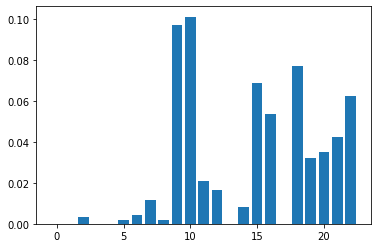

In [37]:
#feature selection using SelectKBest and mutual_info_classif
#not used score funcgtion chi2 as v5 has negative values and chi2 cannot used for neative values. 
fs=SelectKBest(score_func=mutual_info_classif,k='all')
fs.fit(X_train_prepared,y_train)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()


In [38]:
#Iteration 2 - with top 11 features.

fs=SelectKBest(score_func=mutual_info_classif,k=11)
fs.fit(X_train_prepared,y_train)
X_train_fs=fs.transform(X_train_prepared)
X_test_fs=fs.transform(X_test_prepared)

In [39]:
## iteration 2 Decision Tree classifier model with top 11 features

DT_model=DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=10,shuffle=True , random_state=42)
# evaluate model
y_train_pred = cross_val_predict(DT_model, X_train_fs, y_train, cv=cv)

print_score(y_train,y_train_pred,'CV')

# fitting model in whole training set
DT_model.fit(X_train_fs,y_train)

# prediction on test set
y_test_pred=DT_model.predict(X_test_fs)

# score on test set
print_score(y_test,y_test_pred,'Test')


Confusion matrix on CV 
 [[ 204   72]
 [  34 3390]]
Precision on CV :	 0.9792027729636048
Recall on   CV :	 0.990070093457944
F1 score on CV :	 0.9846064478652338


Confusion matrix on Test 
 [[77 30]
 [11 82]]
Precision on Test :	 0.7321428571428571
Recall on   Test :	 0.8817204301075269
F1 score on Test :	 0.7999999999999999




In [40]:
#Iteration 3 - with smote  
from imblearn.pipeline import Pipeline

# oversample the minority class to have 10 percent the number of examples of the majority class. (342)
# random undersampling to reduce the number of records in the majority class to have 50 percent more than the minority class. (684)
k_values=[1,2,3,4,5,6,7,8,9,10]
for k in k_values:
    DT_model3=DecisionTreeClassifier(max_leaf_nodes=38,min_samples_split=2)
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over',over),('under',under),('model',DT_model3)]
    pipeline = Pipeline(steps=steps)
    cv = StratifiedKFold(n_splits=10,shuffle=True , random_state=42)
    y_train_pred = cross_val_predict(pipeline, X_train_prepared, y_train, cv=cv)
    print ('for k value : ', k)
    print_score(y_train,y_train_pred,'CV')


for k value :  1
Confusion matrix on CV 
 [[ 229   47]
 [ 191 3233]]
Precision on CV :	 0.9856707317073171
Recall on   CV :	 0.9442172897196262
F1 score on CV :	 0.9644988066825775


for k value :  2
Confusion matrix on CV 
 [[ 227   49]
 [ 168 3256]]
Precision on CV :	 0.9851739788199697
Recall on   CV :	 0.9509345794392523
F1 score on CV :	 0.967751523257542


for k value :  3
Confusion matrix on CV 
 [[ 230   46]
 [ 187 3237]]
Precision on CV :	 0.9859884252208346
Recall on   CV :	 0.9453855140186916
F1 score on CV :	 0.9652601759355897


for k value :  4
Confusion matrix on CV 
 [[ 233   43]
 [ 228 3196]]
Precision on CV :	 0.9867242976227231
Recall on   CV :	 0.9334112149532711
F1 score on CV :	 0.959327630196608


for k value :  5
Confusion matrix on CV 
 [[ 235   41]
 [ 179 3245]]
Precision on CV :	 0.987522824102252
Recall on   CV :	 0.9477219626168224
F1 score on CV :	 0.9672131147540984


for k value :  6
Confusion matrix on CV 
 [[ 223   53]
 [ 174 3250]]
Precision on CV :	 

In [41]:
## iteration 3 Decision Tree classifier model on all features with SMOTE

over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over',over),('under',under)]
pipeline = Pipeline(steps=steps)
X_train_smote, y_train_smote = pipeline.fit_resample(X_train_prepared, y_train)

# fitting model in whole training set
DT_model3.fit(X_train_smote,y_train_smote)

# prediction on test set
y_test_pred=DT_model3.predict(X_test_prepared)

# confusion matrix for test set
print_score(y_test,y_test_pred,'Test')


Confusion matrix on Test 
 [[71 36]
 [ 9 84]]
Precision on Test :	 0.7
Recall on   Test :	 0.9032258064516129
F1 score on Test :	 0.7887323943661972




In [48]:
#X_train_smote.shape
y_train_smote.value_counts()

1    684
0    342
Name: classLabel, dtype: int64

In [42]:
# Iteration 4 RandomForestClassifier model on all features with SMOTE
RF_model4=RandomForestClassifier(max_leaf_nodes=38,min_samples_split=2)
RF_model4.fit(X_train_smote,y_train_smote)
y_test_pred=RF_model4.predict(X_test_prepared)

# confusion matrix for test set
print_score(y_test,y_test_pred,'Test')


Confusion matrix on Test 
 [[80 27]
 [ 3 90]]
Precision on Test :	 0.7692307692307693
Recall on   Test :	 0.967741935483871
F1 score on Test :	 0.8571428571428572




In [43]:
params = {'max_leaf_nodes': list(range(20, 60)), 'min_samples_split': [2, 3], 'n_estimators' : list(range(50,100))}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_leaf_nodes': [20, 21, 22, 23, 24, 25, 26, 27, 28,
                                            29, 30, 31, 32, 33, 34, 35, 36, 37,
                                            38, 39, 40, 41, 42, 43, 44, 45, 46,
                                            47, 48, 49, ...],
                         'min_samples_split': [2, 3],
                         'n_estimators': [50, 51, 52, 53, 54, 55, 56, 57, 58,
                                          59, 60, 61, 62, 63, 64, 65, 66, 67,
                                          68, 69, 70, 71, 72, 73, 74, 75, 76,
                                          77, 78, 79, ...]},
             verbose=1)

In [44]:
grid_search_cv.best_params_ 

{'max_leaf_nodes': 57, 'min_samples_split': 2, 'n_estimators': 73}

In [50]:
# Iteration 5 RandomForestClassifier model with tuned hyperparameters on all features with SMOTE
RF_model5=RandomForestClassifier(max_leaf_nodes=59,min_samples_split=2,n_estimators=86)
RF_model5.fit(X_train_smote,y_train_smote)
y_test_pred=RF_model5.predict(X_test_prepared)

# confusion matrix for test set
print_score(y_test,y_test_pred,'Test')


Confusion matrix on Test 
 [[82 25]
 [ 3 90]]
Precision on Test :	 0.782608695652174
Recall on   Test :	 0.967741935483871
F1 score on Test :	 0.8653846153846155


